images size: (53879, 32, 32, 3)


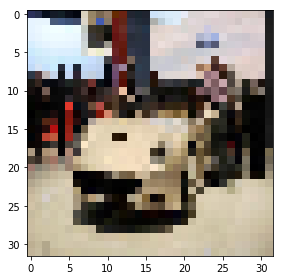

In [1]:
# load data
%matplotlib inline
import numpy as np
import time 
from skimage import io
import json

with open("train/info.json") as f:
    info = json.loads(f.read())

labels = [int(image["label_id"]) for image in info]
names = [image["image_id"] for image in info]
names_labels_list = [[image["image_id"], image["label_id"]] for image in info]
names_labels_dict = dict(names_labels_list)

images = np.load("images.npy")
print("images size:",images.shape)
io.imshow(images[0])

(12500, 4, 32, 32, 3)
(12500, 4)
(12500, 4, 3, 32, 32)


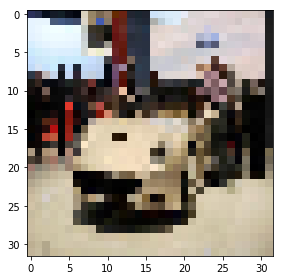

In [2]:
images_train = images[:50000]
images_train = images_train.reshape((12500,4,32,32,3))
labels = np.array(labels)
labels_train = labels[:50000]
labels_train = labels_train.reshape((12500,4))
print(images_train.shape)
print(labels_train.shape)
io.imshow(images_train[0][0])
images_train = np.transpose(images_train,axes=(0,1,4,2,3))
print(images_train.shape)

In [3]:
import torch
images_train = torch.from_numpy(images_train)
labels_train = torch.from_numpy(labels_train)
print(images_train.size())
print(labels_train.size())

torch.Size([12500, 4, 3, 32, 32])
torch.Size([12500, 4])


In [4]:
import torch
from torch.autograd import Variable

# images_train = np.transpose(images_train,axes=(0,1,4,2,3))
# images_train = torch.from_numpy(images_train)
# images_train = Variable(images_train, requires_grad=True)
# labels = np.array(labels)
# labels = labels[:1000]
# labels = labels.reshape((250,4))
# labels = torch.from_numpy(labels)
# labels = Variable(labels, requires_grad=True)
# print(images_train.size())

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, 80)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
net = AlexNet()
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Linear(in_features=256, out_features=80)
)


In [6]:
params = list(net.parameters())
k = 0
for param in params:
    j = 1
    print(param.size())
    for i in param.size():
        j *= i
    k += j
print(k)

torch.Size([96, 3, 11, 11])
torch.Size([96])
torch.Size([256, 96, 5, 5])
torch.Size([256])
torch.Size([384, 256, 3, 3])
torch.Size([384])
torch.Size([384, 384, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([80, 256])
torch.Size([80])
3767760


In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

for epoch in range(5):
    running_loss = 0.0
    for i,inputs in enumerate(images_train,0):
        inputs = inputs.float()
        inputs_labels = labels_train[i] 
        inputs,inputs_labels = Variable(inputs),Variable(inputs_labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,inputs_labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.data[0]
        if i%2000==1999:
            print("[%s,%s] loss:%.3f" %(epoch+1,i+1,running_loss/2000))
            running_loss = 0.0
print("Training completed!")

[1,2000] loss:4.378
[1,4000] loss:4.365
[1,6000] loss:4.359
[1,8000] loss:4.352
[1,10000] loss:4.286
[1,12000] loss:4.155
[2,2000] loss:4.084
[2,4000] loss:4.030
[2,6000] loss:3.994
[2,8000] loss:3.953
[2,10000] loss:3.920
[2,12000] loss:3.838
[3,2000] loss:3.765
[3,4000] loss:3.690
[3,6000] loss:3.662
[3,8000] loss:3.587
[3,10000] loss:3.548
[3,12000] loss:3.494
[4,2000] loss:3.471
[4,4000] loss:3.435
[4,6000] loss:3.422
[4,8000] loss:3.387
[4,10000] loss:3.375
[4,12000] loss:3.329
[5,2000] loss:3.320
[5,4000] loss:3.299
[5,6000] loss:3.288
[5,8000] loss:3.261
[5,10000] loss:3.256
[5,12000] loss:3.216
Training completed!


In [8]:
# criterion = nn.CrossEntropyLoss()
# import torch.optim as optim
# optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

# def train(process_number):
#     for epoch in range(2):
#         running_loss = 0.0
#         for i,inputs in enumerate(images_train,0):
#             inputs = inputs.float()
#             inputs_labels = labels_train[i] 
#             inputs,inputs_labels = Variable(inputs),Variable(inputs_labels)
#             optimizer.zero_grad()
#             outputs = net(inputs)
#             loss = criterion(outputs,inputs_labels)
#             loss.backward()
#             optimizer.step()
#             running_loss+=loss.data[0]
#             if i%2000==1999:
#                 print("进程%s [%s,%s] loss:%.3f" %(process_number,epoch+1,i+1,running_loss/2000))
#                 running_loss = 0.0
#     print("Training completed!")
# from multiprocessing import Process
# for i in range(5):
#     p = Process(target=train,args=(i,))
#     p.start()

images size: (7120, 32, 32, 3)


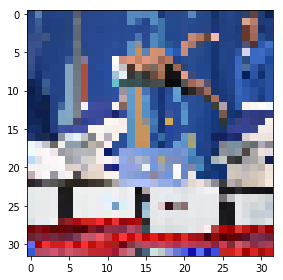

In [9]:
# load data
%matplotlib inline
import numpy as np
import time 
from skimage import io
import json

with open("validation/info.json") as f:
    info = json.loads(f.read())

labels = [int(image["label_id"]) for image in info]
names = [image["image_id"] for image in info]
names_labels_list = [[image["image_id"], image["label_id"]] for image in info]
names_labels_dict = dict(names_labels_list)

images = np.load("images_validation.npy")
print("images size:",images.shape)
io.imshow(images[0])

(250, 4, 32, 32, 3)
(250, 4)
(250, 4, 3, 32, 32)


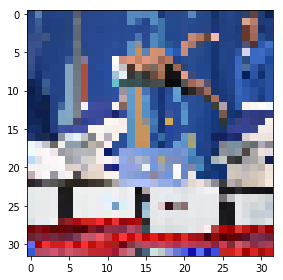

In [10]:
images_validation = images[:1000]
images_validation = images_validation.reshape((250,4,32,32,3))
labels = np.array(labels)
labels_validation = labels[:1000]
labels_validation = labels_validation.reshape((250,4))
print(images_validation.shape)
print(labels_validation.shape)
io.imshow(images_validation[0][0])
images_validation = np.transpose(images_validation,axes=(0,1,4,2,3))
print(images_validation.shape)

In [11]:
import pandas as pd
classes=pd.read_csv('validation/validationClasses.csv',header=None)
classList=list(classes.iloc[:,1])
print('categories:')
print(classList,'\n')

categories:
['航站楼', '停机坪', '机舱', '游乐场', '冰场', '舞台', '艺术室', '流水线', '棒球场', '橄榄球场', '足球场', '排球场', '高尔夫球场', '田径场', '滑雪场', '篮球馆(场)', '健身房', '保龄球馆', '游泳池', '拳击场', '跑马场', '田地/农场', '果园菜园', '牧场', '乡村', '温室', '电视台(演播室)', '亚洲寺庙', '亭子', '塔', '宫殿', '西式教堂', '街道', '餐厅食堂', '咖啡厅', '厨房', '广场', '实验室', '酒吧', '会议室', '办公室', '医院', '售票处', '露营地(帐篷）', '音乐工作室', '电梯/楼梯', '公园/花园', '建筑工地', '大型综合超市', '商店', '集市', '图书馆/书店', '教室', '海洋沙滩', '消防', '加油站', '垃圾场', '阳台', '游戏/棋牌室', '舞厅', '博物馆', '沙漠', '漂流', '树林', '桥', '住宅', '汽车展厅', '河流湖泊', '水族馆', '沟渠', '宴会厅', '卧室', '山', '站台', '草地', '育儿室', '美容/美发店', '修理店', '斗牛场', '雪屋/冰雕(山)'] 



In [12]:
import torch
images_validation = torch.from_numpy(images_validation)
labels_validation = torch.from_numpy(labels_validation)
print(images_validation.size())
print(labels_validation.size())

torch.Size([250, 4, 3, 32, 32])
torch.Size([250, 4])


In [13]:
from torch.autograd import Variable
correct = 0
total = 0
for i,inputs in enumerate(images_validation,0):
    inputs = inputs.float()
    inputs_labels = labels_validation[i]
    inputs = Variable(inputs)
    outputs = net(inputs)
    _,predicted = torch.max(outputs.data,1)
    total += inputs_labels.size(0)
    correct += (predicted == inputs_labels).sum()
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 18 %
